In [1]:
from torch_geometric.datasets import Entities
import os.path as osp
import networkx as nx
import igraph as ig
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch_geometric as pyg

import numpy as np

import LPGNN

device = 'cpu'

In [2]:
mpl.rc('text', usetex=True)

In [3]:
pyg.seed_everything(seed=100)

In [13]:
import importlib
importlib.reload(module=LPGNN.GraphNeuralNet)
importlib.reload(module=LPGNN.network_generator)
importlib.reload(module=LPGNN.network_analysis)
importlib.reload(module=LPGNN.LinkPrediction)

<module 'LPGNN.LinkPrediction' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/LinkPrediction.py'>

In [5]:
# PS Network

N = 200
avg_k = 10
gamma = 2.15
Temp = 0.2
seed = 100
G_nx, G = LPGNN.network_generator.generatePSNetwork_nx(N, avg_k, gamma, Temp, seed)
#G, G_nx, data = LPGNN.DataSetup.get_ps_network(N=300, avg_k=8, gamma=2.5, Temp=0.2, seed=100)
#G_nx.graph['size'] = 60
data = pyg.utils.from_networkx(G_nx)

In [6]:
# Split data
test_ratio = 0.5
val_ratio = 0.1
train_data, val_data, test_data = LPGNN.DataSetup.train_test_split(data, test_ratio=0.5, val_ratio=0.1, neg_samples=True)

In [14]:
## Create train, test and validation graphs in networkx
G_nx_train = G_nx.copy()
G_nx_train.remove_edges_from(test_data.pos_edge_label_index.T.detach().numpy())
G_nx_train.remove_edges_from(val_data.pos_edge_label_index.T.detach().numpy())
G_nx_test = G_nx.copy()
G_nx_test.remove_edges_from(train_data.pos_edge_label_index.T.detach().numpy())
G_nx_test.remove_edges_from(val_data.pos_edge_label_index.T.detach().numpy())
G_nx_val = G_nx.copy()
G_nx_val.remove_edges_from(train_data.pos_edge_label_index.T.detach().numpy())
G_nx_val.remove_edges_from(test_data.pos_edge_label_index.T.detach().numpy())

## Create train graph in igraph
G_train = G.copy()
G_train.delete_edges([(x[0], x[1]) for x in np.transpose(test_data.pos_edge_label_index)])
G_train.delete_edges([(x[0], x[1]) for x in np.transpose(val_data.pos_edge_label_index)])
## If there are disconnected components, join them together by joining single nodes of components to node 0 (oldest and statistically most connected)
added_edges = []
G_train_components = G_train.clusters()
if len(G_train_components) > 1:
    for i, component in enumerate(G_train_components):
        if i == 0:
            continue
        if component[0] != 0:
            G_train.add_edge(0, component[0])
            G_nx_train.add_edge(0, component[0])
            torch.concat((train_data.pos_edge_label_index[0], torch.Tensor([0])))
            torch.concat((train_data.pos_edge_label_index[1], torch.Tensor([component[0]])))
            added_edges.append((0, component[0]))
        else:
            G_train.add_edge(1, component[0])
            G_nx_train.add_edge(1, component[0])
            torch.concat((train_data.pos_edge_label_index[0], torch.Tensor([1])))
            torch.concat((train_data.pos_edge_label_index[1], torch.Tensor([component[0]])))
            added_edges.append((1, component[0]))
print('Added edges: ', added_edges)
## Get LaBNE embedding for train graph
G_train_labne = LPGNN.network_generator.generateLaBNE(graph=G_train)
G_full_labne = LPGNN.network_generator.generateLaBNE(graph=G)

# Set node data to be the LaBNE embedding position, and centrality measures
data.x = torch.Tensor( np.transpose([list(nx.betweenness_centrality(G_nx_train).values()),
                                     list(nx.closeness_centrality(G_nx_train).values())]) )
#data.x = torch.Tensor( np.transpose([G_train_labne.vs['theta'], G_train_labne.vs['r'], list(nx.betweenness_centrality(G_nx_train).values())]) )
# Copy data.x to train/val/test data
train_data.x = val_data.x = test_data.x = data.x

Added edges:  [(0, 60), (0, 102), (0, 122), (0, 151), (0, 158), (0, 179)]


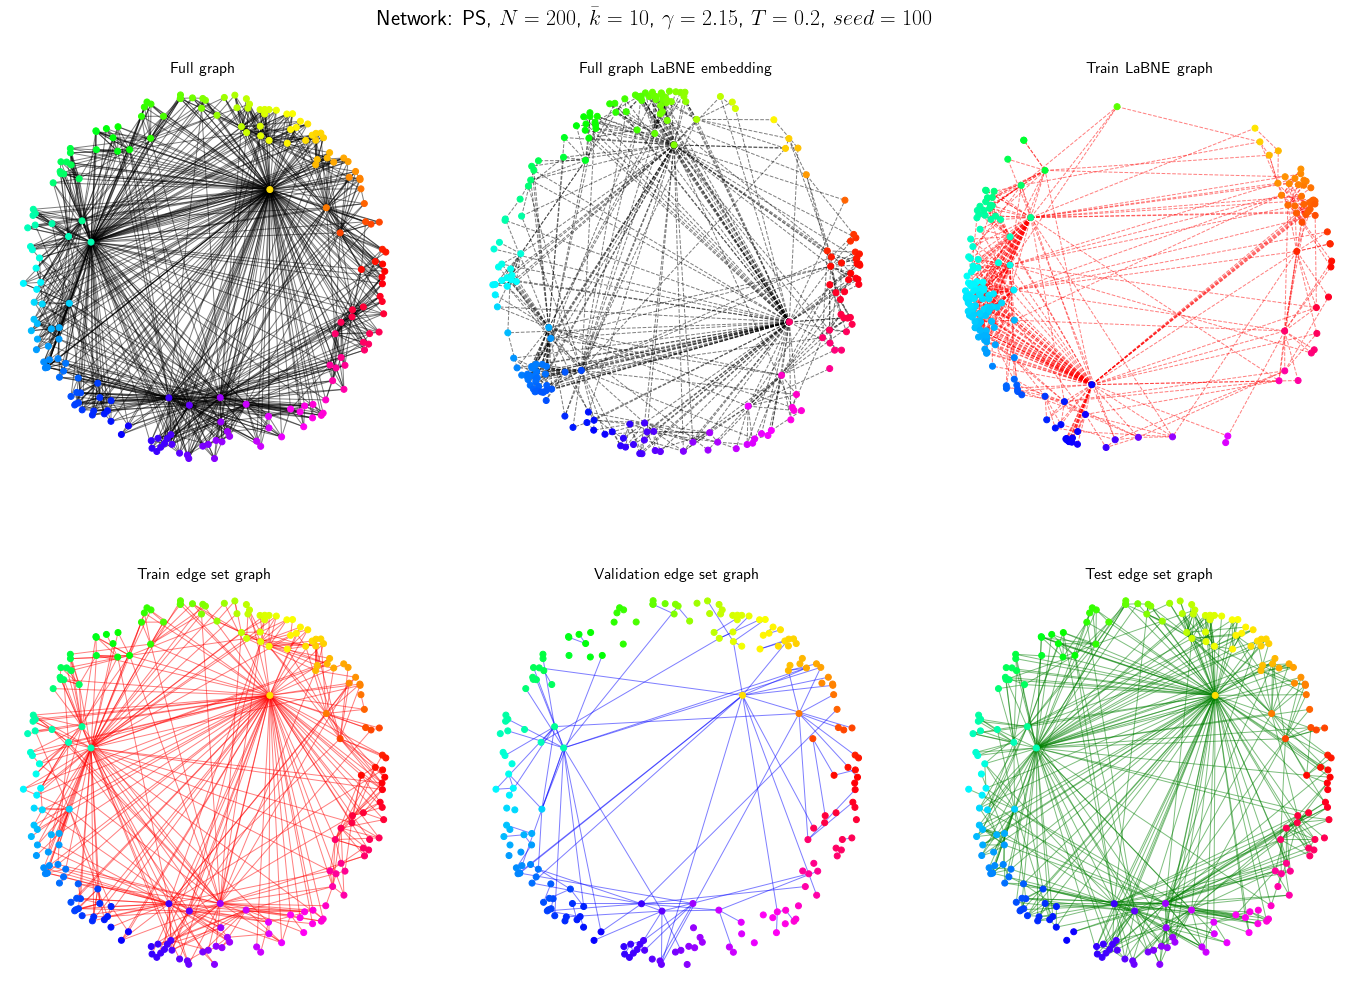

In [7]:
## Draw graph, including subdrawings for train/val/test, and LaBNE
fig = plt.figure(figsize=(24, 16), facecolor='white')
fig.suptitle(fr'Network: PS, $N={N}$, $\bar{{k}}={avg_k}$, $\gamma={gamma}$, $T={Temp}$, $seed={seed}$', fontsize=22)
plt.subplots_adjust(top=0.93) 
ax_full = fig.add_subplot(231, projection='polar')
ax_labne_full = fig.add_subplot(232, projection='polar')
ax_labne_train = fig.add_subplot(233, projection='polar')
ax_train = fig.add_subplot(234, projection='polar')
ax_val = fig.add_subplot(235, projection='polar')
ax_test = fig.add_subplot(236, projection='polar')

## Turn off axis labels, and set titles
ax_full.set_axis_off()
ax_full.set_title('Full graph', fontsize=16)
ax_train.set_axis_off()
ax_train.set_title('Train edge set graph', fontsize=16)
ax_val.set_axis_off()
ax_val.set_title('Validation edge set graph', fontsize=16)
ax_test.set_axis_off()
ax_test.set_title('Test edge set graph', fontsize=16)
ax_labne_full.set_axis_off()
ax_labne_full.set_title('Full graph LaBNE embedding', fontsize=16)
ax_labne_train.set_axis_off()
ax_labne_train.set_title('Train LaBNE graph', fontsize=16)

# Graph position given by original PS generation (not LaBNE)
G_pos = np.transpose([G.vs['theta'], G.vs['r']])

# Draw full graph
nx.draw_networkx_edges(G_nx, G_pos, alpha=0.5, ax=ax_full)
ax_full.scatter(G.vs['theta'], G.vs['r'], c=G_nx.graph['color'])

# Draw train graph
nx.draw_networkx_edges(G_nx_train, G_pos, alpha=0.5, edge_color='red', ax=ax_train)
ax_train.scatter(G.vs['theta'], G.vs['r'], c=G_nx.graph['color'])

# Draw val graph
nx.draw_networkx_edges(G_nx_val, G_pos, alpha=0.5, edge_color='blue', ax=ax_val)
ax_val.scatter(G.vs['theta'], G.vs['r'], c=G_nx.graph['color'])

# Draw test graph
nx.draw_networkx_edges(G_nx_test, G_pos, alpha=0.5, edge_color='green', ax=ax_test)
ax_test.scatter(G.vs['theta'], G.vs['r'], c=G_nx.graph['color'])

# Draw full LaBNE graph
nx.draw_networkx_edges(G_nx_train, np.transpose([G_full_labne.vs['theta'], G_full_labne.vs['r']]), alpha=0.5, edge_color='black', style='dashed', ax=ax_labne_full)
ax_labne_full.scatter(G_full_labne.vs['theta'], G_full_labne.vs['r'], c=G_full_labne.vs['color'])

# Draw train LaBNE graph
nx.draw_networkx_edges(G_nx_train, np.transpose([G_train_labne.vs['theta'], G_train_labne.vs['r']]), alpha=0.5, edge_color='red', style='dashed', ax=ax_labne_train)
ax_labne_train.scatter(G_train_labne.vs['theta'], G_train_labne.vs['r'], c=G_train_labne.vs['color'])

# fig.savefig('../LPGNN/figs/Avance/Networks/PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_' + str(seed) + '.pdf', bbox_inches='tight')
# fig.savefig('../LPGNN/figs/Avance/Networks/PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_' + str(seed) + '.png', bbox_inches='tight')

In [15]:
PR_LaBNE = LPGNN.network_analysis.precision_recall_snapshots(snapshot_t0=G_train, snapshot_t1=G, metric='LaBNE', step=1)

/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/network_analysis.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  link_scores = np.array(link_scores)


In [45]:
importlib.reload(module=LPGNN.GraphNeuralNet)

<module 'LPGNN.GraphNeuralNet' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/GraphNeuralNet.py'>

# SEED

In [46]:
## Model parameters
hidden_channels = 64
out_channels = 2
num_layers = 3
epochs = 6

model_outputs = []
PR = []
for i in range(1):
    pyg.seed_everything(seed=i)
    model = pyg.nn.GraphSAGE(in_channels=data.num_features, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=num_layers)#, root_weight=False, aggr="mean")
    #model = pyg.nn.GCN(in_channels=data.num_features, hidden_channels=40, out_channels=20, num_layers=3)#, root_weight=False, aggr="mean")
    #model = pyg.nn.GAT(in_channels=data.num_features, hidden_channels=40, out_channels=20, num_layers=3)#, root_weight=False, aggr="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model_outputs.append(LPGNN.GraphNeuralNet.train_model(model, optimizer, train_data, test_data, val_data, epochs=epochs, epoch_step=2))

    # Evaluate model
    # model.eval()
    # torch.no_grad()
    z_train = model.forward(train_data.x, train_data.pos_edge_label_index)
    # z_val = LPGNN.GraphNeuralNet.test(model, train_data, val_data)[1]

    ## Generate precision-recall curves
    R, P, preds = LPGNN.LinkPrediction.precision_recall_trained_model(model, train_data, val_data, test_data, norm='dist')
    PR.append([R, P])

    # SAGE_output is now a dictionary. Contains loss curves, train embeddings and final test embedding
    # print(SAGE_output.keys())
    # print("                    Epochs:", SAGE_output['epochs'])
    # print("            Train loss len:", SAGE_output['train loss'].__len__())
    # print("              Val loss len:", SAGE_output['val loss'].__len__())
    # print("           Final test loss:", SAGE_output['test loss'])
    # print("z_train embedding list len:", SAGE_output['z_train'].__len__()) # List of embeddings for train data, one entry for each epoch
    # print("    z_test embedding shape:", SAGE_output['z_test'].shape) # Final embedding of test data, shape (N, model_out_dim)s

tensor(0.0707, grad_fn=<CopyBackwards>)
tensor(0.0784, grad_fn=<CopyBackwards>)
tensor(0.4927, grad_fn=<CopyBackwards>)
tensor(0.0804, grad_fn=<CopyBackwards>)
tensor(0.5573, grad_fn=<CopyBackwards>)
tensor(0.5270, grad_fn=<CopyBackwards>)
tensor(0.0799, grad_fn=<CopyBackwards>)
tensor(0.5623, grad_fn=<CopyBackwards>)
tensor(0.5192, grad_fn=<CopyBackwards>)
tensor(0.5442, grad_fn=<CopyBackwards>)
tensor(0.5194, grad_fn=<CopyBackwards>)
tensor(0.4851, grad_fn=<CopyBackwards>)
tensor(0.5751, grad_fn=<CopyBackwards>)
tensor(0.5464, grad_fn=<CopyBackwards>)
tensor(0.5334, grad_fn=<CopyBackwards>)
tensor(0.4915, grad_fn=<CopyBackwards>)
tensor(0.5234, grad_fn=<CopyBackwards>)
tensor(0.5659, grad_fn=<CopyBackwards>)
tensor(0.5484, grad_fn=<CopyBackwards>)
tensor(0.5111, grad_fn=<CopyBackwards>)
tensor(0.4943, grad_fn=<CopyBackwards>)
tensor(0.5334, grad_fn=<CopyBackwards>)
tensor(0.5348, grad_fn=<CopyBackwards>)
tensor(0.4838, grad_fn=<CopyBackwards>)
tensor(0.5128, grad_fn=<CopyBackwards>)


KeyboardInterrupt: 

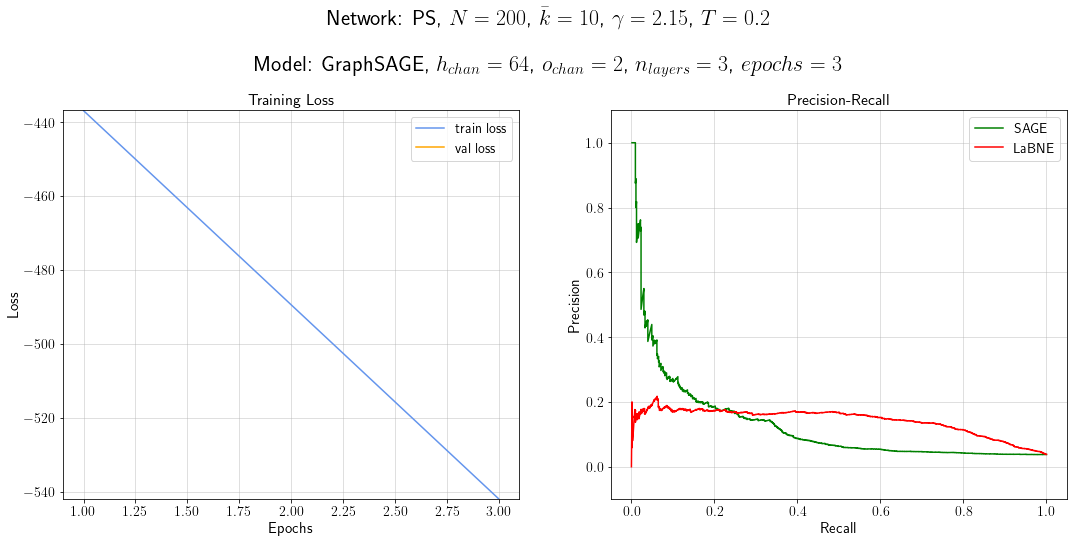

In [41]:
# Plot train and validation losses, as epochs progress

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].set_title(r'Training Loss', fontsize=16)
ax[1].set_title(r'Precision-Recall', fontsize=16)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[0].set_xlabel(r'Epochs', fontsize=15)
ax[1].set_xlabel(r'Recall', fontsize=15)
ax[0].set_ylabel(r'Loss', fontsize=15)
ax[1].set_ylabel(r'Precision', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle(fr'Network: PS, $N={N}$, $\bar{{k}}={avg_k}$, $\gamma={gamma}$, $T={Temp}$' + 
               '\n\n' + 
             fr'Model: GraphSAGE, $h_{{chan}} = {hidden_channels}$, $o_{{chan}} = {out_channels}$, $n_{{layers}} = {num_layers}$, $epochs = {epochs-1}$', 
            fontsize=22)
plt.subplots_adjust(top=0.8) 

#included_seeds = [1, 2, 3, 6, len(model_outputs)]
included_seeds = [len(model_outputs)]
min_loss = np.min([model_outputs[i]['train loss'] for i in range(len(model_outputs))])
max_loss = np.max([model_outputs[i]['train loss'] for i in range(len(model_outputs))])
ax[0].set_ylim(min_loss.detach().numpy()-0.1, max_loss.detach().numpy()+0.1)
for i_s in included_seeds:
  # ax[0].cla()
  # ax[1].cla()
  for artist in ax[0].lines:
    artist.remove()
  for artist in ax[1].lines:
    artist.remove()
  ax[0].set_prop_cycle(None)
  ax[1].set_prop_cycle(None)
  for i in range(i_s):
      ax[0].plot(model_outputs[i]['epochs'], model_outputs[i]['train loss'], c='cornflowerblue', label='train loss' if i == 0 else '_nolegend_')
      # ax[0].plot(model_outputs[i]['epochs'], model_outputs[i]['val loss'], c=p[-1].get_color(), linestyle='dashed', label='val loss')
      ax[0].plot(model_outputs[i]['epochs'], model_outputs[i]['val loss'], c='orange', label='val loss' if i == 0 else '_nolegend_')
      ax[1].plot(PR[i][0], PR[i][1], c='green', label='SAGE' if i == 0 else '_nolegend_')
      #ax.plot(SAGE_output['epochs'], SAGE_output['val loss'], label='val loss')
  ax[1].plot(PR_LaBNE['recall'], PR_LaBNE['precision'], c='red', label='LaBNE')
  #ax[0].set_ylim(-0.1, 1.1)
  ax[1].set_ylim(-0.1, 1.1)
  #ax[0].set_xlim(-10, 50)
  if i == 0:
    ax[0].legend(loc='upper right', fontsize=14)
    ax[1].legend(loc='upper right', fontsize=14)
  # Include PS information and model information in savename
  # fig.savefig('../LPGNN/figs/Avance/Loss_PR/NoColor/Seeds_' + str(i_s) + '_Loss_PR_' + 'PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_GraphSAGE_' + str(hidden_channels) + '_' + str(out_channels) + '_' + str(num_layers) + '_' + str(epochs) + '.pdf', bbox_inches='tight')
  # fig.savefig('../LPGNN/figs/Avance/Loss_PR/NoColor/Seeds_' + str(i_s) + '_Loss_PR_' + 'PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_GraphSAGE_' + str(hidden_channels) + '_' + str(out_channels) + '_' + str(num_layers) + '_' + str(epochs) + '.png', bbox_inches='tight')

In [220]:
#
importlib.reload(LPGNN.GraphNeuralNet)
edge_index = torch.cat([train_data.pos_edge_label_index, train_data.neg_edge_label_index], dim=-1)

In [179]:
train_data.neg_edge_label_index.size(1)

489

In [146]:
LPGNN.GraphNeuralNet.hyperbolic_distance(u=z_train[0], v=z_train[1])

tensor(0.0447, grad_fn=<LogBackward0>)

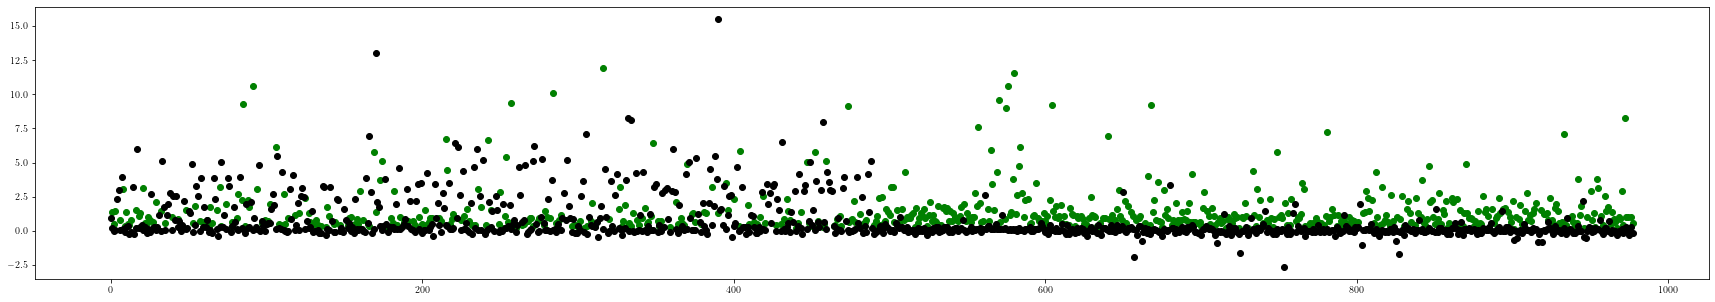

In [232]:
logits_orthogonal = (z_train[edge_index[0]] * z_train[edge_index[1]]).sum(dim=-1)
logits_distance = (z_train[edge_index[0]] - z_train[edge_index[1]] + 0.01).norm(dim=-1)
logits_hyperbolic = LPGNN.GraphNeuralNet.hyperbolic_logits(z_train, train_data.pos_edge_label_index, train_data.neg_edge_label_index)
labels = LPGNN.GraphNeuralNet.get_link_labels(pos_edge_index=train_data.pos_edge_label_index, neg_edge_index=train_data.neg_edge_label_index)
#logits = (logits.sigmoid() - 1) * 4 + 1
fig, ax = plt.subplots(figsize=(30,5))
#ax.scatter(np.arange(labels.shape[0]), logits_orthogonal.detach().numpy(), c='black', label='Logits')
#ax.scatter(np.arange(labels.shape[0]), logits_distance.detach().numpy(), c='red', label='Logits')
ax.scatter(np.arange(labels.shape[0]), logits_hyperbolic.detach().numpy(), c='green', label='Logits')
ax.scatter(np.arange(labels.shape[0]), logits_orthogonal.detach().numpy(), c='black', label='Logits')
#ax.scatter(np.arange(logits.shape[0]), labels.detach().numpy(), c='red', label='Labels')
#plt.ylim(-100, 100.01)

# Output Dimension

In [29]:
## Model parameters
hidden_channels = 128
out_channels = [8, 16, 32, 64, 128, 200, 512]
num_layers = 3
epochs = 101

pyg.seed_everything(seed=10)

model_outputs = []
PR = []
for out in out_channels:
    model = pyg.nn.GraphSAGE(in_channels=data.num_features, hidden_channels=hidden_channels, out_channels=out, num_layers=num_layers)#, root_weight=False, aggr="mean")
    #model = pyg.nn.GCN(in_channels=data.num_features, hidden_channels=40, out_channels=20, num_layers=3)#, root_weight=False, aggr="mean")
    #model = pyg.nn.GAT(in_channels=data.num_features, hidden_channels=40, out_channels=20, num_layers=3)#, root_weight=False, aggr="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model_outputs.append(LPGNN.GraphNeuralNet.train_model(model, optimizer, train_data, test_data, val_data, epochs=epochs, epoch_step=2))

    # Evaluate model
    # model.eval()
    # torch.no_grad()
    # z_train = model.forward(train_data.x, train_data.pos_edge_label_index)
    # z_val = LPGNN.GraphNeuralNet.test(model, train_data, val_data)[1]

    ## Generate precision-recall curves
    R, P, preds = LPGNN.LinkPrediction.precision_recall_trained_model(model, train_data, val_data, test_data, norm='dist')
    PR.append([R, P])

    # SAGE_output is now a dictionary. Contains loss curves, train embeddings and final test embedding
    # print(SAGE_output.keys())
    # print("                    Epochs:", SAGE_output['epochs'])
    # print("            Train loss len:", SAGE_output['train loss'].__len__())
    # print("              Val loss len:", SAGE_output['val loss'].__len__())
    # print("           Final test loss:", SAGE_output['test loss'])
    # print("z_train embedding list len:", SAGE_output['z_train'].__len__()) # List of embeddings for train data, one entry for each epoch
    # print("    z_test embedding shape:", SAGE_output['z_test'].shape) # Final embedding of test data, shape (N, model_out_dim)s

(-0.1, 1.1)

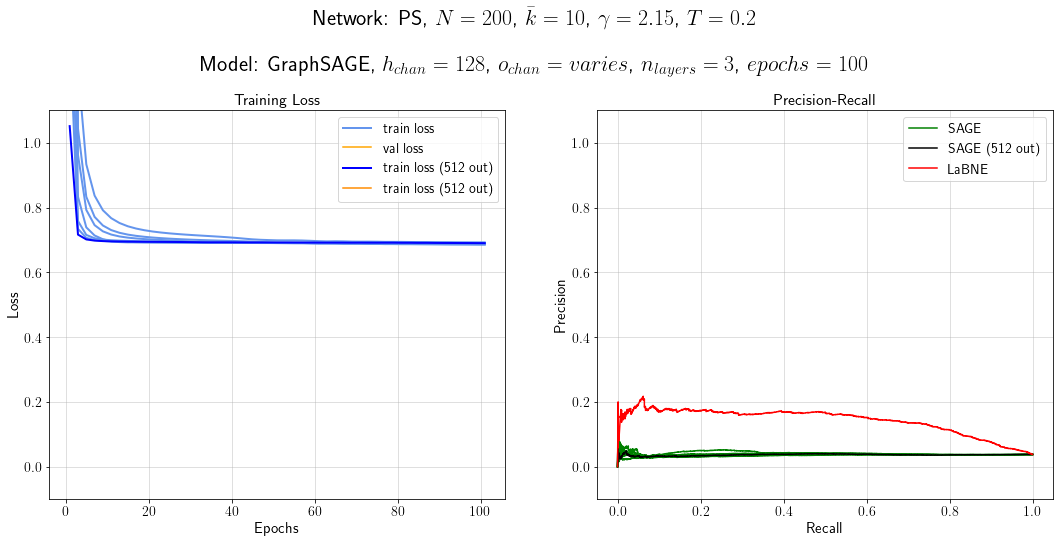

In [30]:
# Plot train and validation losses, as epochs progress

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].set_title(r'Training Loss', fontsize=16)
ax[1].set_title(r'Precision-Recall', fontsize=16)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[0].set_xlabel(r'Epochs', fontsize=15)
ax[1].set_xlabel(r'Recall', fontsize=15)
ax[0].set_ylabel(r'Loss', fontsize=15)
ax[1].set_ylabel(r'Precision', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle(fr'Network: PS, $N={N}$, $\bar{{k}}={avg_k}$, $\gamma={gamma}$, $T={Temp}$' + 
               '\n\n' + 
             fr'Model: GraphSAGE, $h_{{chan}} = {hidden_channels}$, $o_{{chan}} = varies$, $n_{{layers}} = {num_layers}$, $epochs = {epochs-1}$', 
            fontsize=22)
plt.subplots_adjust(top=0.8) 

min_loss = np.min([model_outputs[i]['train loss'] for i in range(len(model_outputs))])
max_loss = np.max([model_outputs[i]['train loss'] for i in range(len(model_outputs))])
ax[0].set_ylim(min_loss.detach().numpy()-0.1, 1)
for i, out_channel in enumerate(out_channels):
  # ax[0].cla()
  # ax[1].cla()
  ax[0].plot(model_outputs[i]['epochs'], model_outputs[i]['train loss'], c='cornflowerblue' if out_channel != 512 else 'blue', 
             label='train loss' if i==0 else "_nolegend_" if out_channel != 512 else "train loss (512 out)", linewidth=2)
  ax[0].plot(model_outputs[i]['epochs'], model_outputs[i]['val loss'], c='orange' if out_channel != 512 else 'darkorange', 
             label='val loss' if i==0 else "_nolegend_" if out_channel != 512 else "train loss (512 out)")
  ax[1].plot(PR[i][0], PR[i][1], c='green' if out_channel != 512 else 'black', 
             label='SAGE' if i == 0 else "_nolegend_" if out_channel != 512 else 'SAGE (512 out)')
  #ax.plot(SAGE_output['epochs'], SAGE_output['val loss'], label='val loss')
ax[1].plot(PR_LaBNE['recall'], PR_LaBNE['precision'], label='LaBNE', c='red')
ax[0].legend(loc='upper right', fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.1)  
# Include PS information and model information in savename
# fig.savefig('../LPGNN/figs/Avance/Loss_PR/NoColor/Out_Channels_' + '_Loss_PR_' + 'PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_GraphSAGE_' + str(hidden_channels) + '_' + str(num_layers) + '_' + str(epochs) + '.pdf', bbox_inches='tight')
# fig.savefig('../LPGNN/figs/Avance/Loss_PR/NoColor/Out_Channels_' + '_Loss_PR_' + 'PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_GraphSAGE_' + str(hidden_channels) + '_' + str(num_layers) + '_' + str(epochs) + '.png', bbox_inches='tight')

# Hidden Dimension

In [158]:
## Model parameters
hidden_channels = [16, 32, 64, 128, 256, 512]
out_channels = 512
num_layers = 3
epochs = 101

pyg.seed_everything(seed=10)

model_outputs = []
PR = []
for hidden in hidden_channels:
    model = pyg.nn.GraphSAGE(in_channels=data.num_features, hidden_channels=hidden, out_channels=out_channels, num_layers=num_layers)#, root_weight=False, aggr="mean")
    #model = pyg.nn.GCN(in_channels=data.num_features, hidden_channels=40, out_channels=20, num_layers=3)#, root_weight=False, aggr="mean")
    #model = pyg.nn.GAT(in_channels=data.num_features, hidden_channels=40, out_channels=20, num_layers=3)#, root_weight=False, aggr="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model_outputs.append(LPGNN.GraphNeuralNet.train_model(model, optimizer, train_data, test_data, val_data, epochs=epochs, epoch_step=2))

    # Evaluate model
    # model.eval()
    # torch.no_grad()
    z_train = model.forward(train_data.x, train_data.pos_edge_label_index)
    # z_val = LPGNN.GraphNeuralNet.test(model, train_data, val_data)[1]

    ## Generate precision-recall curves
    R, P, preds = LPGNN.LinkPrediction.precision_recall_trained_model(model, train_data, val_data, test_data, norm='dist')
    PR.append([R, P])

    # SAGE_output is now a dictionary. Contains loss curves, train embeddings and final test embedding
    # print(SAGE_output.keys())
    # print("                    Epochs:", SAGE_output['epochs'])
    # print("            Train loss len:", SAGE_output['train loss'].__len__())
    # print("              Val loss len:", SAGE_output['val loss'].__len__())
    # print("           Final test loss:", SAGE_output['test loss'])
    # print("z_train embedding list len:", SAGE_output['z_train'].__len__()) # List of embeddings for train data, one entry for each epoch
    # print("    z_test embedding shape:", SAGE_output['z_test'].shape) # Final embedding of test data, shape (N, model_out_dim)s

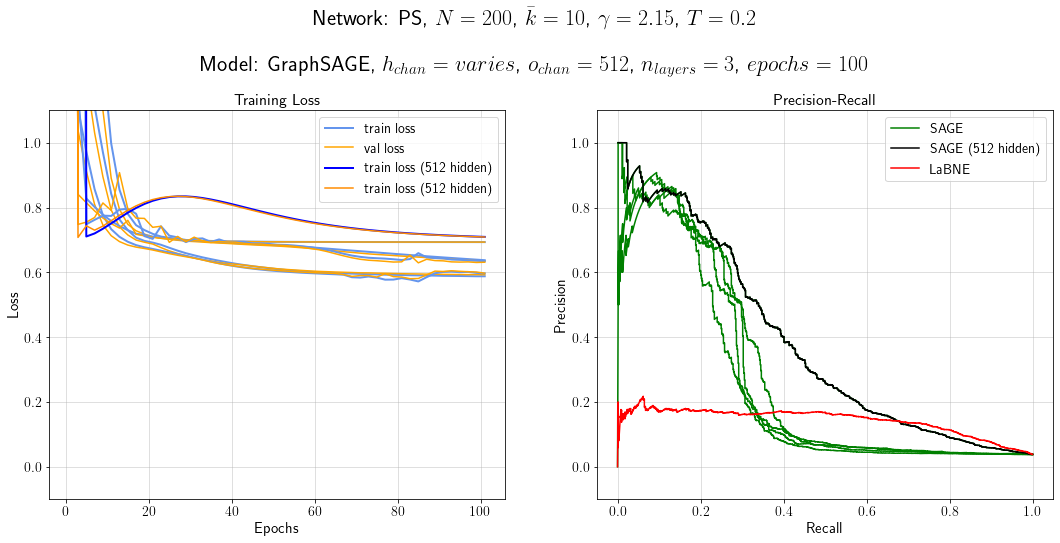

In [160]:
# Plot train and validation losses, as epochs progress

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].set_title(r'Training Loss', fontsize=16)
ax[1].set_title(r'Precision-Recall', fontsize=16)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
ax[0].set_xlabel(r'Epochs', fontsize=15)
ax[1].set_xlabel(r'Recall', fontsize=15)
ax[0].set_ylabel(r'Loss', fontsize=15)
ax[1].set_ylabel(r'Precision', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle(fr'Network: PS, $N={N}$, $\bar{{k}}={avg_k}$, $\gamma={gamma}$, $T={Temp}$' + 
               '\n\n' + 
             fr'Model: GraphSAGE, $h_{{chan}} = varies$, $o_{{chan}} = {out_channels}$, $n_{{layers}} = {num_layers}$, $epochs = {epochs-1}$', 
            fontsize=22)
plt.subplots_adjust(top=0.8) 

min_loss = np.min([model_outputs[i]['train loss'] for i in range(len(model_outputs))])
max_loss = np.max([model_outputs[i]['train loss'] for i in range(len(model_outputs))])
for i, hidden_channel in enumerate(hidden_channels):
  # ax[0].cla()
  # ax[1].cla()
  ax[0].plot(model_outputs[i]['epochs'], model_outputs[i]['train loss'], c='cornflowerblue' if hidden_channel != 512 else 'blue', 
             label='train loss' if i==0 else "_nolegend_" if hidden_channel != 512 else "train loss (512 hidden)", linewidth=2)
  ax[0].plot(model_outputs[i]['epochs'], model_outputs[i]['val loss'], c='orange' if hidden_channel != 512 else 'darkorange', 
             label='val loss' if i==0 else "_nolegend_" if hidden_channel != 512 else "train loss (512 hidden)")
  ax[1].plot(PR[i][0], PR[i][1], c='green' if hidden_channel != 512 else 'black', 
             label='SAGE' if i == 0 else "_nolegend_" if hidden_channel != 512 else 'SAGE (512 hidden)')
  #ax.plot(SAGE_output['epochs'], SAGE_output['val loss'], label='val loss')
ax[1].plot(PR_LaBNE['recall'], PR_LaBNE['precision'], label='LaBNE', c='red')
ax[0].legend(loc='upper right', fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.1, 1.1)
# Include PS information and model information in savename
fig.savefig('../LPGNN/figs/Avance/Loss_PR/NoColor/Hidden_Channels_' + '_Loss_PR_' + 'PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_GraphSAGE_' + str(out_channels) + '_' + str(num_layers) + '_' + str(epochs) + '.pdf', bbox_inches='tight')
fig.savefig('../LPGNN/figs/Avance/Loss_PR/NoColor/Hidden_Channels_' + '_Loss_PR_' + 'PS_' + str(N) + '_' + str(avg_k) + '_' + str(gamma) + '_' + str(Temp) + '_GraphSAGE_' + str(out_channels) + '_' + str(num_layers) + '_' + str(epochs) + '.png', bbox_inches='tight')

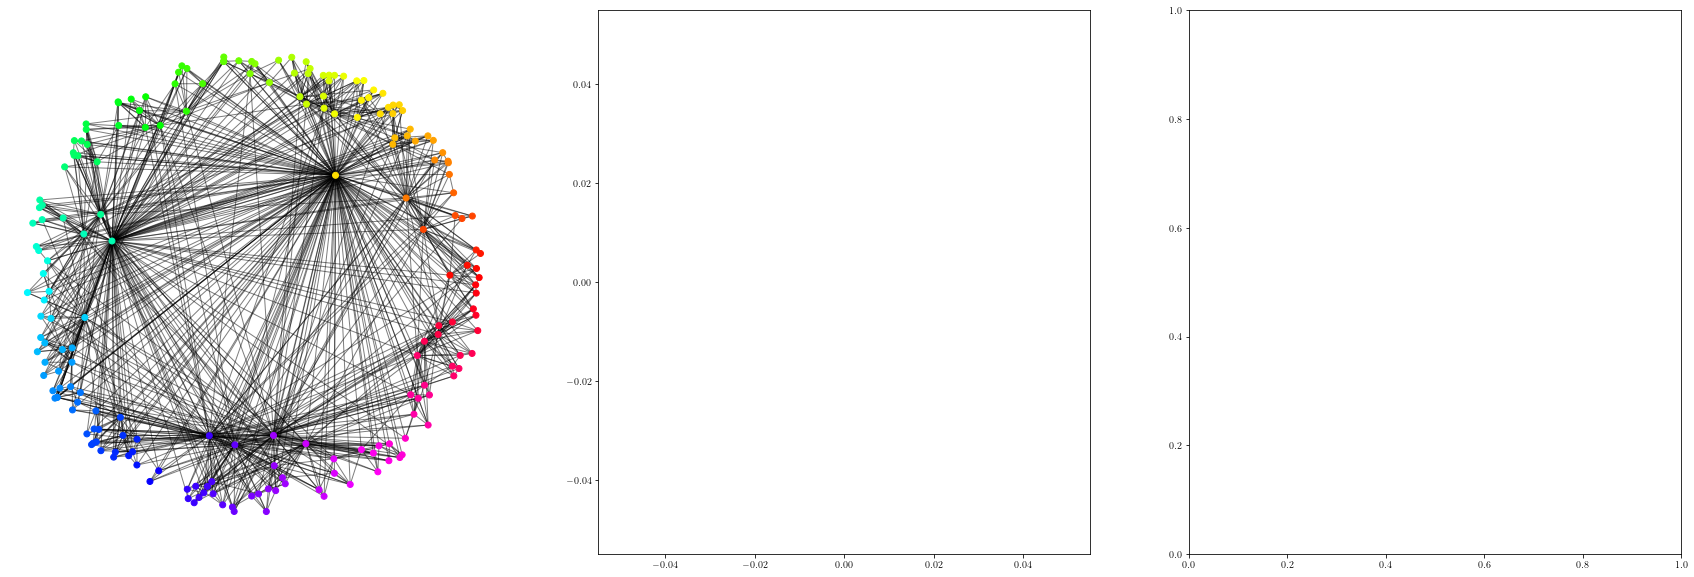

In [35]:
fig = plt.figure(figsize=(30, 10))
ax_labne = fig.add_subplot(131, projection='polar')
ax_gnn_e = fig.add_subplot(132)
ax_gnn_e1 = fig.add_subplot(133)
#ax_gnn_h = fig.add_subplot(133, projection='polar')

ax_labne.set_axis_off()
nx.draw_networkx_edges(G_nx, np.transpose([G.vs['theta'], G.vs['r']]), alpha=0.5, ax=ax_labne)
#axs[0].scatter(xyG[:,0], xyG[:,1], c=G_nx.graph['color'])
ax_labne.scatter(G.vs['theta'], G.vs['r'], c=G_nx.graph['color'])
ax_gnn_e.scatter(z_train[:,0].detach().numpy(), z_train[:,1].detach().numpy(), c=G_nx.graph['color'])
#ax_gnn_e1.scatter(z_val[:,0].detach().numpy(), z_val[:,1].detach().numpy(), c=G_nx.graph['color'])
#ax_gnn_h.scatter(list(G_nx.graph['theta'].values()), list(G_nx.graph['r'].values()), c=G_nx.graph['color'])

In [198]:
R, P, preds = LPGNN.LinkPrediction.precision_recall_trained_model(model, train_data, val_data, test_data, norm='prob_adj')
R_dist, P_dist, preds_dist = LPGNN.LinkPrediction.precision_recall_trained_model(model, train_data, val_data, test_data, norm='dist')
#PR_LaBNE = LPGNN.network_analysis.precision_recall_snapshots(snapshot_t0=G_train, snapshot_t1=G, metric='LaBNE', step=1)
# PR_LaBNE = LPGNN.GraphNeuralNet.LaBNE(PS=G, test=test_data)

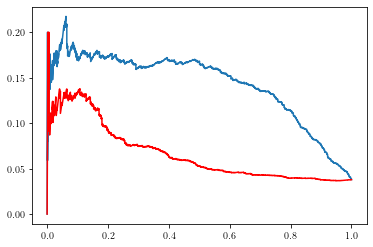

In [200]:
#plt.plot(R, P)
plt.plot(PR_LaBNE['recall'], PR_LaBNE['precision'])
plt.plot(R_dist, P_dist, c='r')

# plt.ylim(-0.01, 0.05)
# plt.xlim(0.8, 1.1)

In [66]:
def hyperbolic_distance(u, v):
    sqdist = torch.sum((u - v) ** 2, dim=-1)
    squnorm = torch.sum(u ** 2, dim=-1)
    sqvnorm = torch.sum(v ** 2, dim=-1)
    x = 1 + 2 * sqdist / ((1 - squnorm) * (1 - sqvnorm)) + 0.01
    z = torch.sqrt(x ** 2 - 1)
    return torch.log(x + z)

In [72]:
hyperbolic_distance(z[train_data.pos_edge_label_index], z[train_data.neg_edge_label_index]).flatten().shape

torch.Size([978])

In [78]:
u = torch.Tensor([[1, 1]])
v = torch.Tensor([[10, 1]])
hyperbolic_distance(u, v)

tensor([1.6219])

In [119]:
z = torch.Tensor([[1, 1], [1, -1], [2, 5], [-1, 6]])

In [96]:
hyperbolic_distance(z[[0,1]], z[[1,2]])

tensor([0.9713, 0.6049])

In [95]:
train_data.pos_edge_label_index.shape

torch.Size([2, 489])

In [120]:
(z[[0,0,1]] * z[[1,2,3]]).sum(dim=1)

tensor([ 0.,  7., -7.])

In [43]:
sigmoid = torch.nn.Sigmoid()

In [126]:
def bce(logits, labels):
    L = 0
    for i in range(logits.shape[0]):
        print(labels[i], np.log(sigmoid(logits[i])), (1-labels[i]), np.log(1-sigmoid(logits[i])))
        L -= labels[i]*np.log(sigmoid(logits[i])) + (1-labels[i])*np.log(1-sigmoid(logits[i]))
    return L/logits.shape[0]

In [127]:
bce(logits, labels)

tensor(1.) tensor(-0.4943) tensor(0.) tensor(-0.9415)
tensor(1.) tensor(-0.4943) tensor(0.) tensor(-0.9415)
tensor(1.) tensor(-0.4943) tensor(0.) tensor(-0.9415)
tensor(1.) tensor(-0.4943) tensor(0.) tensor(-0.9415)
tensor(0.) tensor(-0.6931) tensor(1.) tensor(-0.6931)
tensor(0.) tensor(-0.6931) tensor(1.) tensor(-0.6931)
tensor(0.) tensor(-0.6931) tensor(1.) tensor(-0.6931)
tensor(0.) tensor(-0.6931) tensor(1.) tensor(-0.6931)
tensor(1.) tensor(-0.4943) tensor(0.) tensor(-0.9415)


tensor(0.5827)

$$ \mathcal{L} = -\frac{1}{N} \sum A_{ij}\log{(\sigma(p_{ij}))} + (1-A_{ij})\log{(\sigma(1-p_{ij}))} $$

En nuestro modelo, 

In [152]:
def bce(logits, labels):
    L = 0
    for i in range(logits.shape[0]):
        print(labels[i], np.log(sigmoid(logits[i])), (1-labels[i]), np.log(1-sigmoid(logits[i])))
        L -= labels[i]*np.log(sigmoid(logits[i])) + (1-labels[i])*np.log(1-sigmoid(logits[i]))
    return L/logits.shape[0]

In [153]:
logits = torch.cat((torch.ones(1)*13, torch.zeros(1)), 0)
target = torch.cat((torch.ones(1), torch.zeros(1)), 0)

In [154]:
torch.nn.functional.binary_cross_entropy_with_logits(logits, target), bce(logits, target)

tensor(1.) tensor(-2.2650e-06) tensor(0.) tensor(-12.9979)
tensor(0.) tensor(-0.6931) tensor(1.) tensor(-0.6931)


(tensor(0.3466), tensor(0.3466))

In [84]:
logits = LPGNN.GraphNeuralNet.decode(z=z_train, pos_edge_index=train_data.pos_edge_label_index, neg_edge_index=train_data.neg_edge_label_index)
labels = LPGNN.GraphNeuralNet.get_link_labels(pos_edge_index=train_data.pos_edge_label_index, neg_edge_index=train_data.neg_edge_label_index)
torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)

tensor(0.5210, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [108]:
labels = labels.type(torch.FloatTensor)

In [110]:
crit(logits2, labels)

RuntimeError: expected scalar type Long but found Float

In [37]:
G = nx.Graph([[0,1],[0,2],[0,3],[1,3]])

In [38]:
pos3d = np.array([[1,0,0],[1,1,0],[1,-1,0],[1,1,1]])

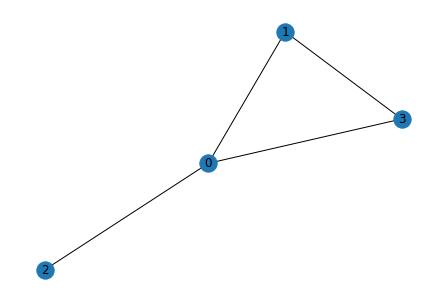

In [39]:
nx.draw(G, with_labels=True)

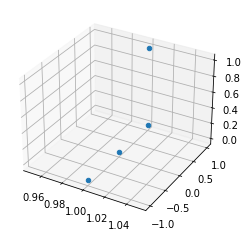

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pos3d[:,0], pos3d[:,1], pos3d[:,2], depthshade=0)
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
# ax.set_zlim(-1,1)

In [44]:
x = torch.Tensor(np.linspace(-10, 10, 100))

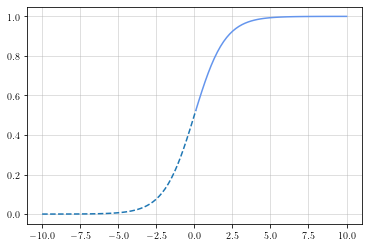

In [167]:
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(alpha=0.5)

ax.plot(x[:51], s[:51], linestyle='dashed')
ax.plot(x[50:], s[50:], c='cornflowerblue')